In [1]:
import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

init_notebook_mode(connected=True) #do not miss this line

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 36.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [2]:
datafile = 'data_elonmusk.csv'

In [3]:
import pandas as pd
tweets = pd.read_csv(datafile, encoding='latin1')
tweets = tweets.assign(Time=pd.to_datetime(tweets.Time)).drop('row ID', axis='columns')

print("Number of tweets: ",len(tweets['Tweet']))
tweets.head(5)

Number of tweets:  3218


,Tweet,Time,Retweet from,User
0,@MeltingIce Assuming max acceleration of 2 to ...,2017-09-29 17:39:19,NaN,elonmusk
1,RT @SpaceX: BFR is capable of transporting sat...,2017-09-29 10:44:54,SpaceX,elonmusk
2,@bigajm Yup :),2017-09-29 10:39:57,NaN,elonmusk
3,Part 2 https://t.co/8Fvu57muhM,2017-09-29 09:56:12,NaN,elonmusk
4,Fly to most places on Earth in under 30 mins a...,2017-09-29 09:19:21,NaN,elonmusk


In [4]:
'''import plotly.plotly as py
import plotly.graph_objs as go
'''
tweets['Time'] = pd.to_datetime(tweets['Time'], format='%y-%m-%d %H:%M:%S')
tweetsT = tweets['Time']

trace = go.Histogram(
    x=tweetsT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Tweet Activity Over Years',
    height=450,
    width=1200,
    xaxis=dict(
        title='Month and year'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [trace]

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Assuming you have defined your 'data' and 'layout' somewhere in the code

# Create a Figure
fig = go.Figure(data=data, layout=layout)

# Display the plot in Colab
pio.show(fig, renderer='colab')

In [6]:
corpus=[]
a=[]
for i in range(len(tweets['Tweet'])):
        a=tweets['Tweet'][i]
        corpus.append(a)

corpus[0:10]

["@MeltingIce Assuming max acceleration of 2 to 3 g's, but in a comfortable direction. Will feel like a mild to moder? https://t.co/fpjmEgrHfC",
 'RT @SpaceX: BFR is capable of transporting satellites to orbit, crew and cargo to the @Space_Station and completing missions to the Moon an?',
 '@bigajm Yup :)',
 'Part 2 https://t.co/8Fvu57muhM',
 'Fly to most places on Earth in under 30 mins and anywhere in under 60. Cost per seat should be? https://t.co/dGYDdGttYd',
 'RT @SpaceX: Supporting the creation of a permanent, self-sustaining human presence on Mars. https://t.co/kCtBLPbSg8 https://t.co/ra6hKsrOcG',
 'BFR will take you anywhere on Earth in less than 60 mins https://t.co/HWt9BZ1FI9',
 'Mars City\nOpposite of Earth. Dawn and dusk sky are blue on Mars and day sky is red. https://t.co/XHcZIdgqnb',
 'Moon Base Alpha https://t.co/voY8qEW9kl',
 "Will be announcing something really special at today's talk https://t.co/plXTBJY6ia"]

In [8]:
tweets.head(5)

,Tweet,Time,Retweet from,User
0,@MeltingIce Assuming max acceleration of 2 to ...,2017-09-29 17:39:19,NaN,elonmusk
1,RT @SpaceX: BFR is capable of transporting sat...,2017-09-29 10:44:54,SpaceX,elonmusk
2,@bigajm Yup :),2017-09-29 10:39:57,NaN,elonmusk
3,Part 2 https://t.co/8Fvu57muhM,2017-09-29 09:56:12,NaN,elonmusk
4,Fly to most places on Earth in under 30 mins a...,2017-09-29 09:19:21,NaN,elonmusk


In [9]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
# removing common words and tokenizing
list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'elon.dict'))  # store the dictionary, for future reference

#print(dictionary)
#print(dictionary.token2id)

In [12]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'elon.mm'), corpus)  # store to disk, for later use

In [13]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

In [14]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

In [15]:
total_topics = 5

In [16]:
lda = gensim.models.LdaMulticore(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [17]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

[(0,
  '0.007*"rocket" + 0.006*"tesla" + 0.006*"launch" + 0.005*"good" + 0.005*"falcon"'),
 (1,
  '0.005*"tesla" + 0.003*":)" + 0.003*"would" + 0.003*"like" + 0.003*"solar"'),
 (2,
  '0.015*"model" + 0.012*"tesla" + 0.004*"first" + 0.004*"@elonmusk" + 0.004*"rocket"'),
 (3,
  '0.010*"tesla" + 0.007*"model" + 0.006*"like" + 0.004*"@teslamotors" + 0.003*"@spacex:"'),
 (4,
  '0.009*"launch" + 0.008*"tesla" + 0.005*"falcon" + 0.004*"model" + 0.004*"..."')]

In [18]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

In [19]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(5, 61)


In [20]:
df_lda

,rocket,tesla,launch,good,falcon,9,landing,next,space,like,...,stage,autopilot,flight,spacex,hyperloop,best,cape,lot,great,battery
0,0.007186,0.005768,0.005740,0.004845,0.004786,0.004042,0.003619,0.003612,0.002894,0.002812,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.002549,0.004884,0.000000,0.001930,0.001807,0.000000,0.000000,0.000000,0.000000,0.002851,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.003527,0.011594,0.002826,0.002284,0.002026,0.000000,0.002798,0.000000,0.000000,0.002932,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.002560,0.009520,0.000000,0.002061,0.001843,0.000000,0.001871,0.002732,0.000000,0.006122,...,0.00182,0.001748,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.002405,0.007583,0.008950,0.002912,0.004808,0.003164,0.002124,0.002396,0.000000,0.000000,...,0.00000,0.000000,0.003273,0.003192,0.002328,0.001989,0.001857,0.001821,0.001778,0.001773


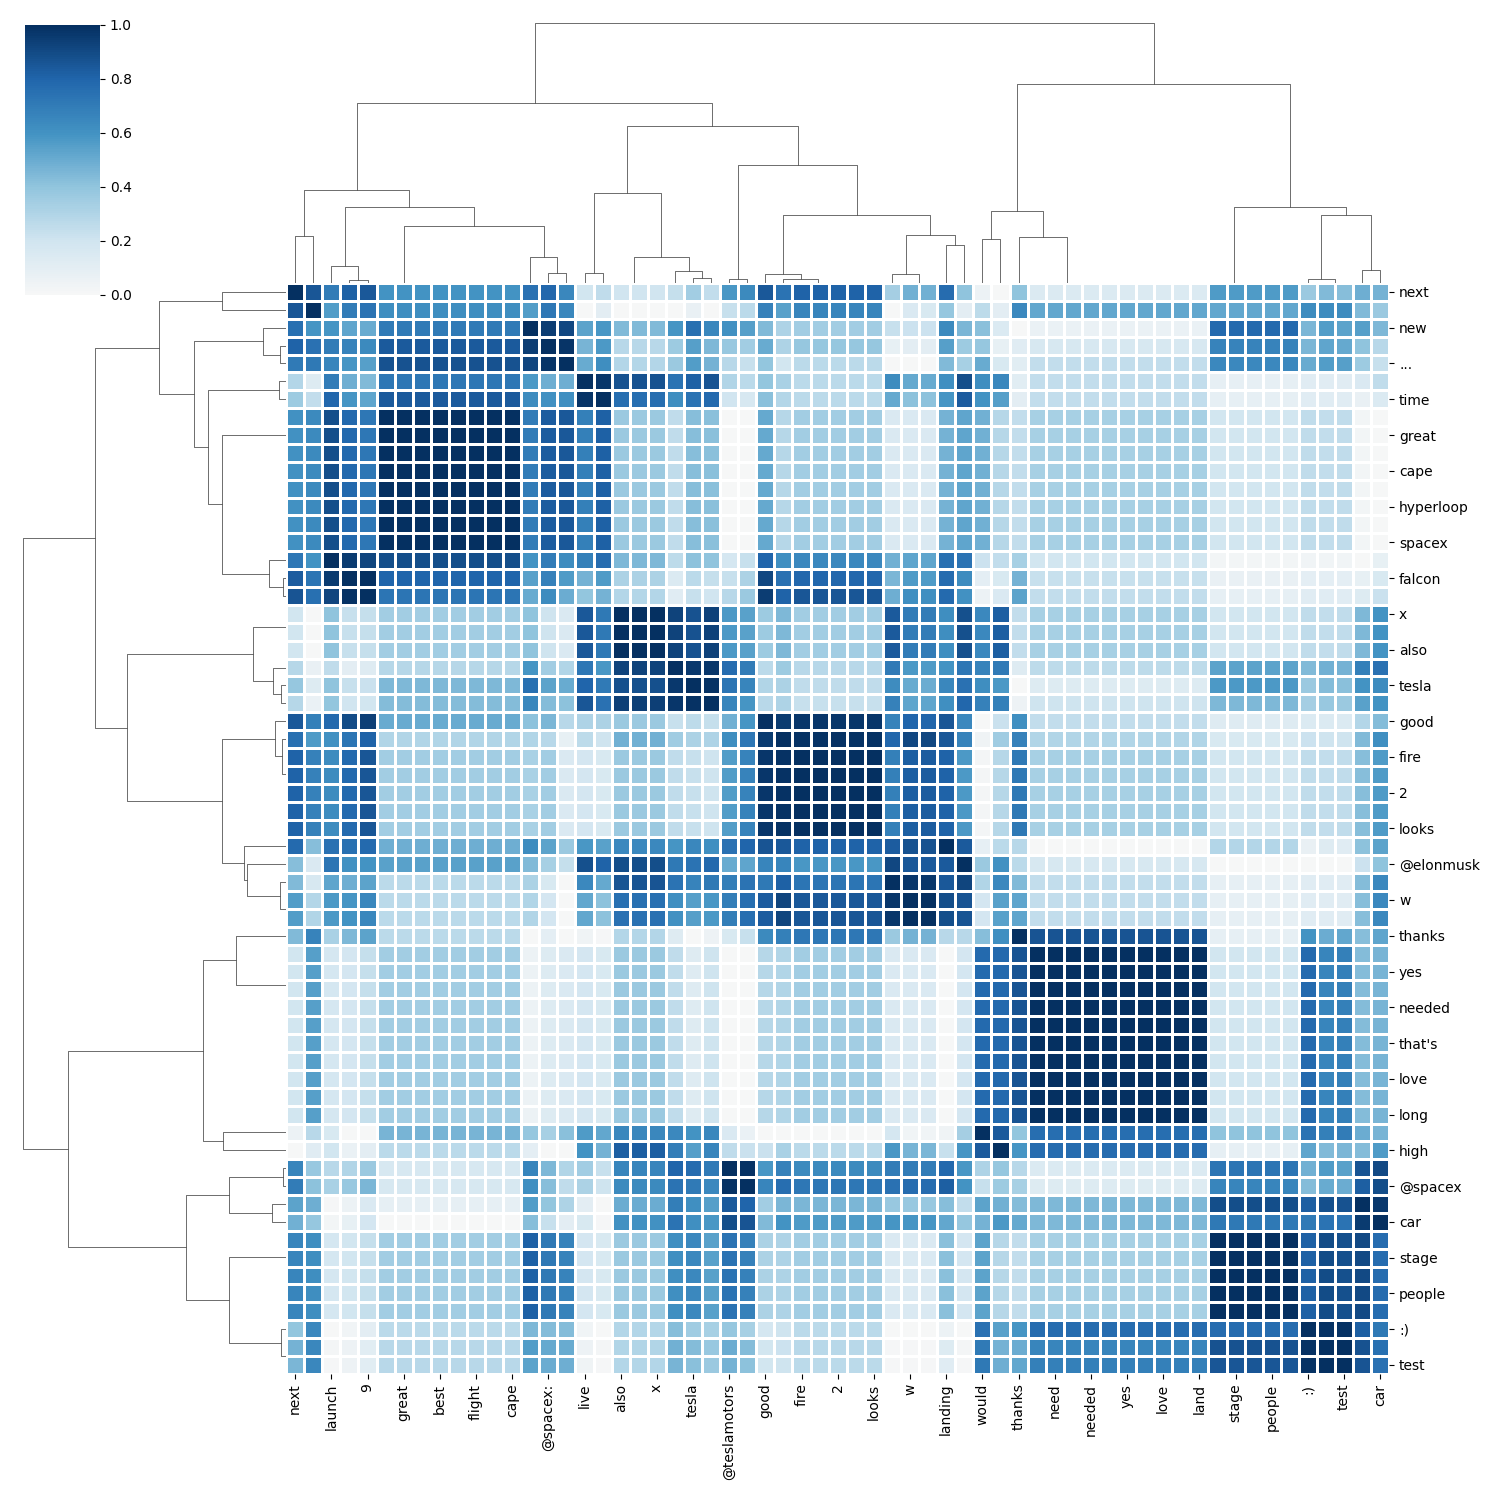

In [21]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis